In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
sess = tf.InteractiveSession()

&emsp;设置超参数

In [2]:
BATCH_START = 0     # 建立 batch data 时候的 index
TIME_STEPS = 20     # backpropagation through time 的 time_steps
BATCH_SIZE = 50     
INPUT_SIZE = 1      # sin 数据输入 size
OUTPUT_SIZE = 1     # cos 数据输出 size
CELL_SIZE = 10        # lstm 的 cell 神经元数
LR = 0.006          # learning rate

&emsp;用于生成数据  
&emsp;np.arrange()生成等差数列,BATCH_START为起点,BATCH_START+TIME_STEPS\*BATCH_SIZE为终点,默认步长为1。作为横坐标  
&emsp;seq与cos分别是sin曲线与cos曲线的纵坐标  
&emsp;np.newaxis是增加一个新维度,是None的一个别名

In [3]:
def get_batch():
    global BATCH_START
    xs = np.arange(BATCH_START, BATCH_START + TIME_STEPS * BATCH_SIZE).reshape(BATCH_SIZE, TIME_STEPS) / (10 * np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]

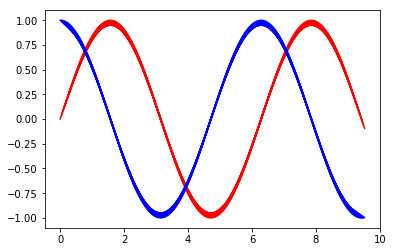

In [4]:
xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape(BATCH_SIZE, TIME_STEPS) / (10*np.pi)
seq = np.sin(xs)
res = np.cos(xs)
plt.plot(xs[0:15, :], seq[0:15, :],'r', xs[0:15, :], res[0:15, :], 'b')
plt.show()

&emsp;LSTM类及方法声明

In [5]:
class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys')
            self.W_in = tf.Variable(tf.random_normal([input_size, cell_size]))
            self.B_in = tf.Variable(tf.constant(0.1, shape = [cell_size]))
            self.W_out = tf.Variable(tf.random_normal([cell_size, output_size]))
            self.B_out= tf.Variable(tf.constant(0.1, shape = [output_size]))
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):
            self.add_cell()
        with tf.variable_scope('out_hidden'):
            self.add_output_layer()
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op = tf.train.GradientDescentOptimizer(LR).minimize(self.cost)
            
    def add_input_layer(self):
        reshape_xs = tf.reshape(self.xs, [-1, self.input_size]) 
        x_in =  tf.matmul(reshape_xs, self.W_in) + self.B_in
        self.x_in = tf.reshape(x_in, [-1, self.n_steps, self.cell_size])
        
    def add_cell(self):
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.cell_size, forget_bias = 1.0, state_is_tuple = True)
        self.init_state = lstm_cell.zero_state(self.batch_size, dtype = tf.float32)
        self.x_out, self.states = tf.nn.dynamic_rnn(lstm_cell, self.x_in, initial_state = self.init_state, time_major = False)
    
    #这里的x_out不同于基于lstm进行minst预测时的情况，需要先reshape，这是因为minst分类时只需要最后一个output的值，而这里需要所有时刻的output
    def add_output_layer(self):
        self.x_out = tf.reshape(self.x_out, [-1, self.cell_size])
        self.pred = tf.matmul(self.x_out, self.W_out) + self.B_out
        
    def compute_cost(self):
        self.cost = tf.reduce_mean(tf.square(tf.subtract(tf.reshape(self.pred, [-1]), tf.reshape(self.ys, [-1]))))

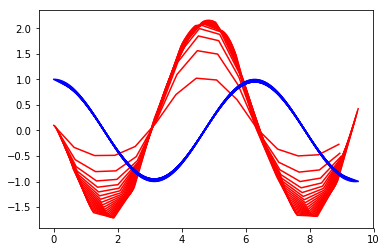

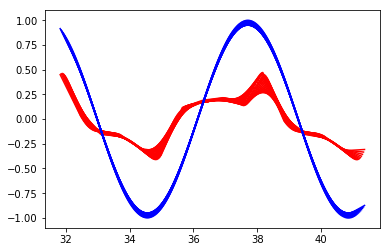

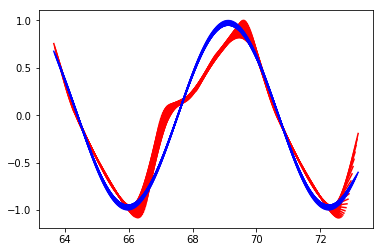

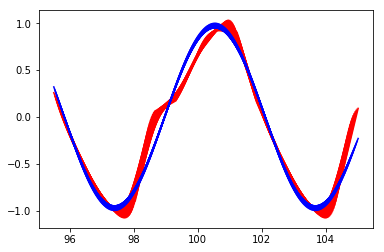

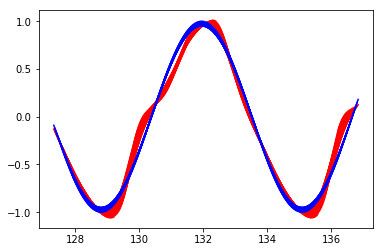

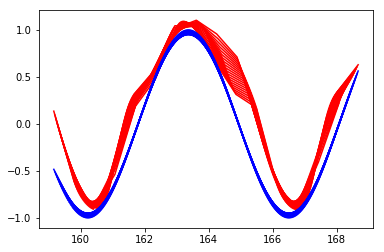

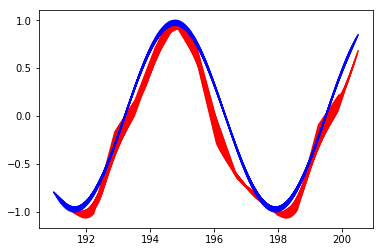

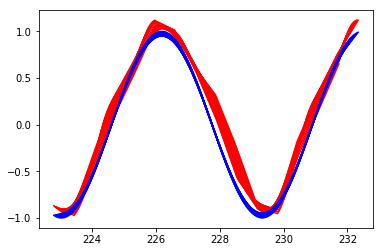

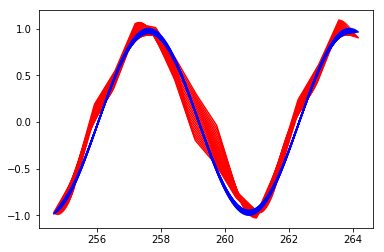

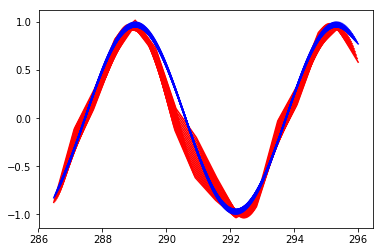

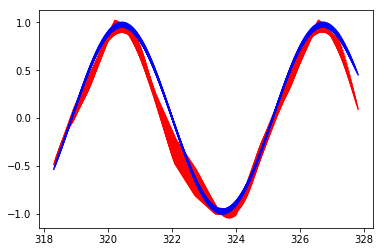

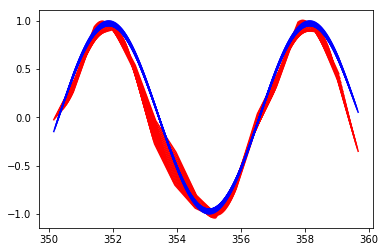

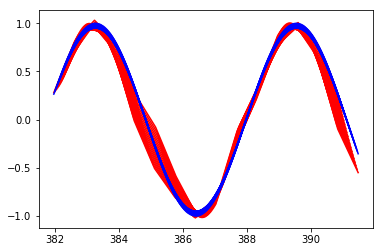

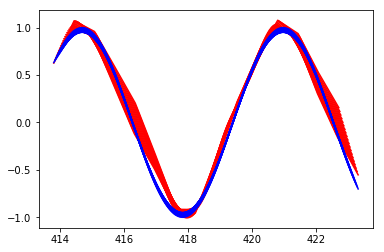

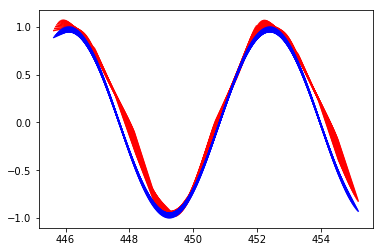

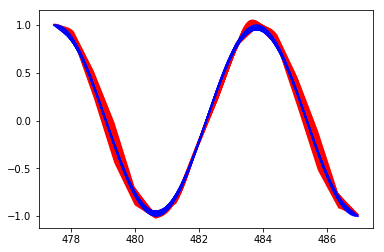

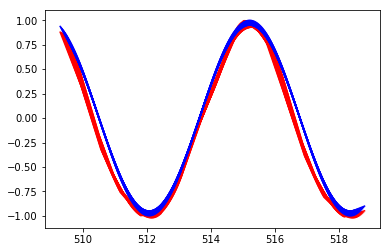

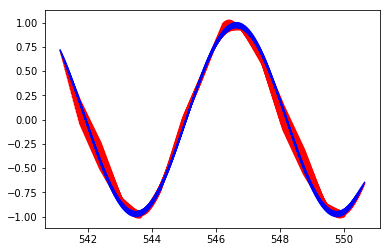

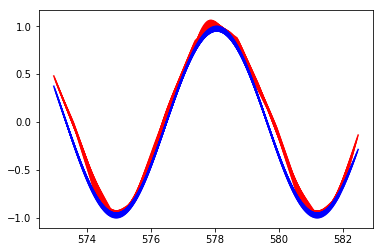

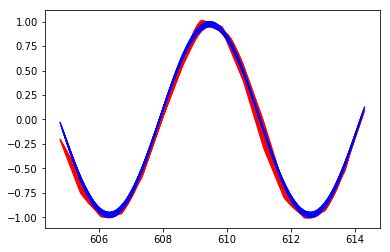

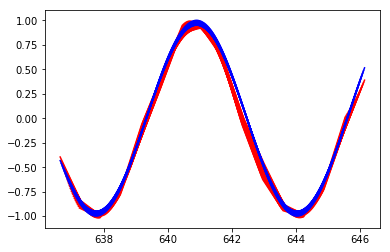

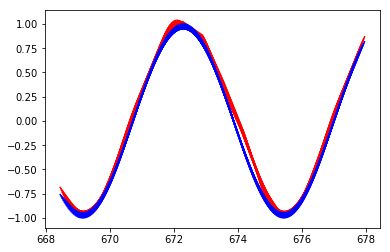

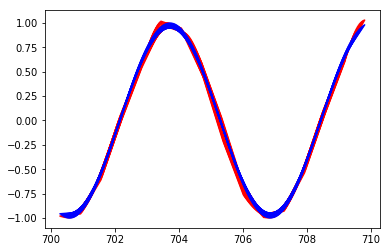

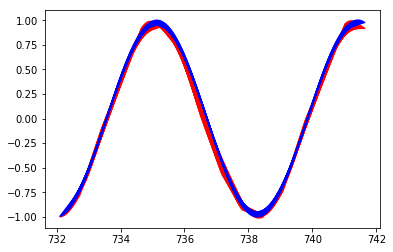

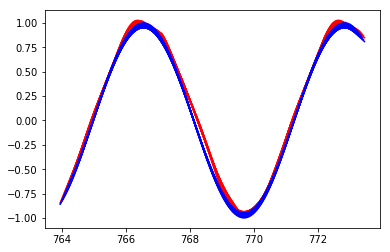

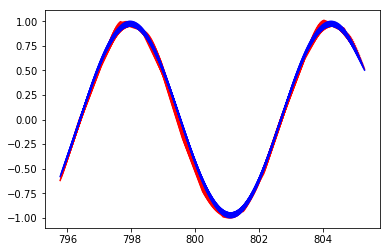

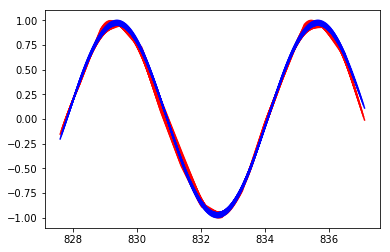

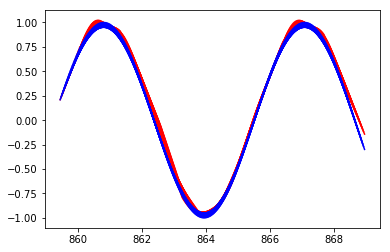

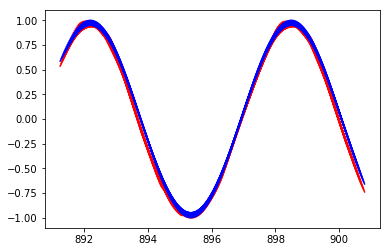

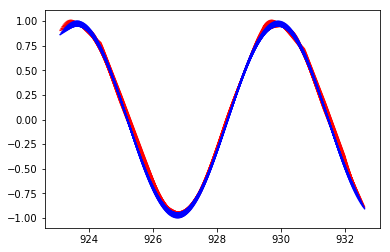

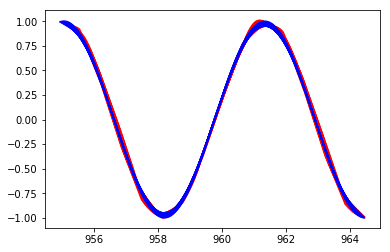

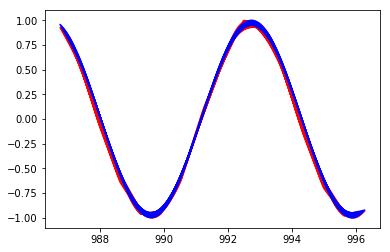

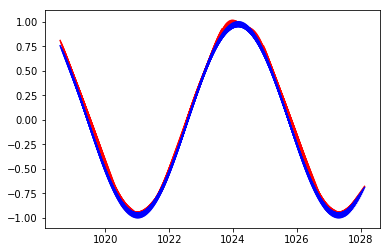

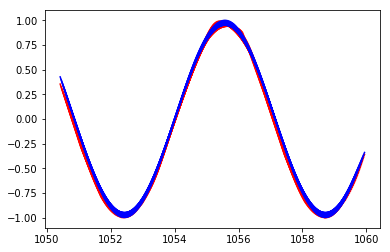

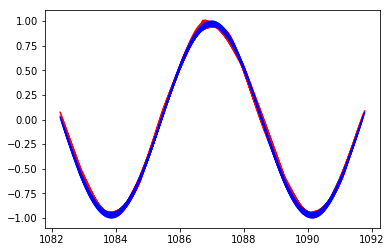

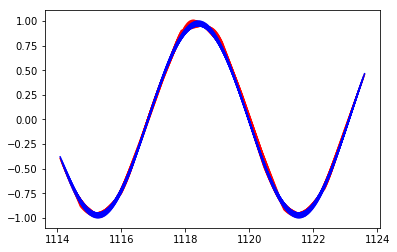

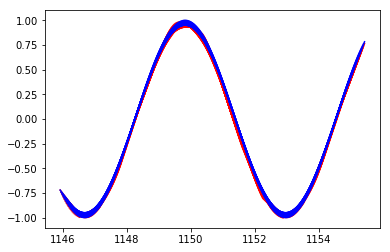

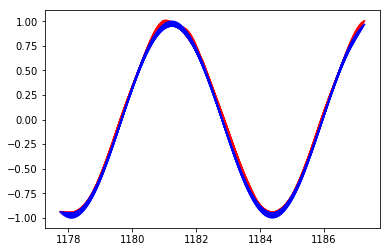

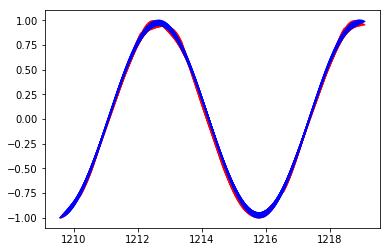

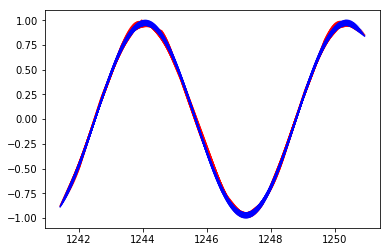

In [6]:
if __name__ == '__main__':
    # 搭建 LSTMRNN 模型
    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    sess.run(tf.global_variables_initializer())
    
    # 训练 200 次
    for i in range(2000):
        seq, res, xs = get_batch()  # 提取 batch data
        if i == 0:
        # 初始化 data
            feed_dict = {
                    model.xs: seq,
                    model.ys: res,
            }
        else:
            feed_dict = {
                model.xs: seq,
                model.ys: res,
                model.init_state: state    # 保持 state 的连续性
            }
        
        # 训练
        _, cost, state, pred = sess.run(
            [model.train_op, model.cost, model.states, model.pred],
            feed_dict = feed_dict)
        
        # 打印 cost 结果
        if i % 50 == 0:
            res_show = res.reshape(BATCH_SIZE, TIME_STEPS)
            pred_show = pred.reshape(BATCH_SIZE, TIME_STEPS)    
            plt.plot(xs[0:15, :], pred_show[0:15, :], 'r', xs[0:15, :], res_show[0:15, :], 'b')
            plt.show()